In [1]:
!pip install lmfit
!pip install requests

In [38]:

from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint
import scipy.optimize as optim
import pandas as pd
from lmfit import Parameters, minimize, report_fit
import requests

In [39]:
def getParams(N,p,beta,gamma,sigma,tc,eps):
    fit_params = Parameters()
    fit_params.add('N', value=N,vary=False)
    fit_params.add('p', value=p,min=1, max=1e6)
    fit_params.add('beta', value=beta, min=0, max=10) #0.2
    fit_params.add('gamma', value=gamma, min=0, max=1.0)#0.02
    fit_params.add('sigma', value=sigma, min=0, max=1.0)#0.01
    fit_params.add('tc', value=tc,vary=False)#20
    fit_params.add('eps', value=eps, vary=False)#8
    return fit_params

In [40]:
def getCountryData(country):
  r = requests.get('https://api.covid19api.com/dayone/country/'+country)
  res=r.json()
  df=pd.DataFrame(res)
  df=df[df["Province"]==""]
  I=np.array(df['Confirmed'])
  return I
N=36e6
I=getCountryData("FR")

In [41]:
def logistic(t,a,b,c):
    return c/(1+a*np.exp(-b*t))

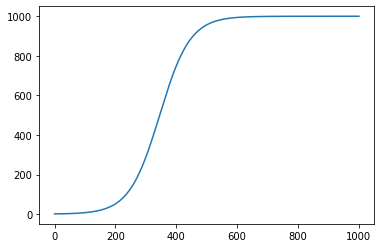

In [42]:
plt.plot(logistic(np.linspace(0,10,1001),999,2,1000))

array([   798.52450569,    872.01261675,    952.23618673,   1039.80722825,
         1135.392342  ,   1239.71738904,   1353.57252494,   1477.8176162 ,
         1613.38805896,   1761.30101914,   1922.66211162,   2098.67253397,
         2290.63666729,   2499.97015263,   2728.20844652,   2977.01585224,
         3248.19501556,   3543.69686306,   3865.63094902,   4216.27616141,
         4598.09171959,   5013.72837452,   5466.03969707,   5958.09331025,
         6493.18188668,   7074.83369341,   7706.82242121,   8393.17598533,
         9138.18392858,   9946.40299671,  10822.66038976,  11772.05412351,
        12799.94986275,  13911.97351614,  15113.99881241,  16412.12901522,
        17812.67188192,  19322.10693796,  20947.0441289 ,  22694.1729357 ,
        24570.20110445,  26581.78225956,  28735.43184913,  31037.43112307,
        33493.71917565,  36109.77350148,  38890.48001657,  41839.99408255,
        44961.59472777,  48257.53496604,  51728.89184017,  55375.42052437,
        59195.41745543,  

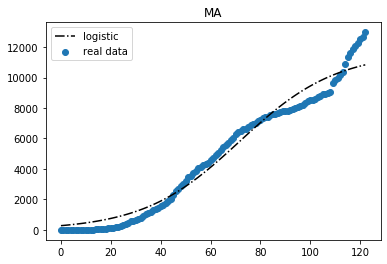

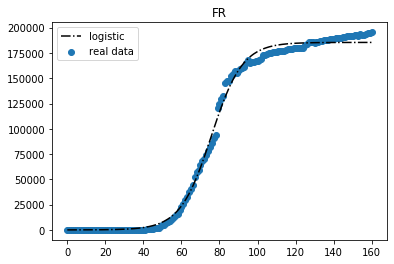

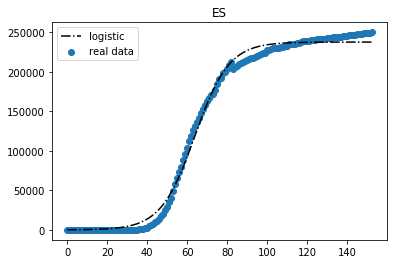

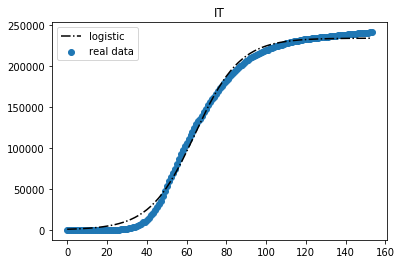

In [43]:
def fitFor(countryCode,forcast):
    N=36e6
    I=getCountryData(countryCode)
    n=I.size
    x=np.linspace(0,n-1,n)
    plt.figure()
    #plt.plot(x,I,linestyle='dotted',color="red", label="real")
    plt.scatter(x,I,label="real data")
    bounds=(0,[1e6,10,36e6])
    p0=np.random.exponential(size=3)
    (a,b,c),cov=optim.curve_fit(logistic,x,I,bounds=bounds,p0=p0)
    #print(a,b,c)
    x=np.linspace(0,n-1+forcast,n+forcast)
    Y=logistic(x,a,b,c)
    plt.plot(x,Y,label="logistic", linestyle='dashdot', color="black")
    plt.legend()
    plt.title(countryCode)
    return Y
Y=fitFor("MA",0)
fitFor("FR",0)
fitFor("ES",0)
fitFor("IT",0)



In [45]:
fit_params = Parameters()
fit_params.add('K', value=1e4,vary=False)
fit_params.add('tc', value=40,vary=False)
fit_params.add('eps', value=15,vary=False)
fit_params.add('gamma', value=1, min=0)
fit_params.add('p', value=0.1, min=0,max=0.99)
fit_params.add('r', value=1, min=0)

In [46]:
def getP(Tc,Tmax,p,eps):
    P=np.ones(Tmax+1)
    for i in range(Tc,Tc+eps+1):
      P[i]=1+(p-1)*(i-Tc)/eps 
    for i in range(Tc+eps+1,Tmax+1):
      P[i]=p
    return P

def l(r,P):
    return np.power(r,P)
    

In [47]:
def deriv(y, x, K , r,gamma, p,tc,eps):
    I = y
    pp=1
    if(tc<x<tc+eps): pp=1+(p-1)*(x-tc)/eps 
    elif(tc+eps<x): pp=p
    dIdt = r*l(I,pp)*(1-np.power(I/K,gamma))
    return dIdt

In [48]:
def f(params,x,y0):
    K= params["K"]
    p= params["p"].value
    eps= params["eps"].value
    tc= params["tc"].value
    gamma= params["gamma"].value
    r= params["r"].value
    return (odeint(deriv, y0, x, args=(K,r,gamma,p,tc,eps)).T)[0]


In [49]:
def objective(params,f,x,data,y0):
    # Initial number of infected and recovered individuals, I0 and R0.
    ndata=x.size
    resid = 0.0*data
    ret=f(params,x,y0)
    resid= data- ret
    return resid.flatten()

123
[[Variables]]
    K:      27086.4192 +/- 3913.18656 (14.45%) (init = 10000)
    tc:     40 (fixed)
    eps:    15 (fixed)
    gamma:  0.06354109 +/- 0.07230199 (113.79%) (init = 1)
    p:      0.87158341 +/- 0.02356521 (2.70%) (init = 0.1)
    r:      0.63278178 +/- 0.61259610 (96.81%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, r) = -1.000
    C(p, r)     =  0.949
    C(gamma, p) = -0.946
    C(K, p)     = -0.818
    C(K, r)     = -0.625
    C(K, gamma) =  0.614


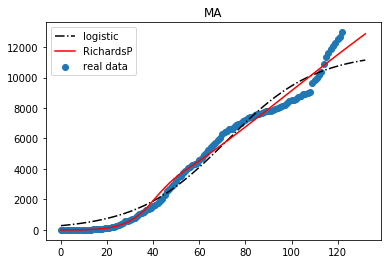

In [53]:
fit_params = Parameters()
fit_params.add('K', value=1e4,vary=True)
fit_params.add('tc', value=40,vary=False)
fit_params.add('eps', value=15,vary=False)
fit_params.add('gamma', value=1, min=0)
fit_params.add('p', value=0.1, min=0,max=0.99)
fit_params.add('r', value=1, min=0)

data=getCountryData("MA")
n=data.shape[0]
print(n)
x=np.linspace(1,n,n)
y0=1

out = minimize(objective, fit_params,  args=(f,x,data,y0))
report_fit(out.params)
x=np.linspace(1,n+10,n+10)
sim=f(out.params,x,1)
fitFor("MA",10)
#plt.figure()

plt.plot(sim,label="RichardsP",color="red")
#plt.plot(data,linestyle="dotted",label="real")
plt.legend()
plt.savefig("finalresult.png", dpi=150)

161
[[Variables]]
    K:      190561.969 +/- 1308.33132 (0.69%) (init = 100000)
    tc:     53 (fixed)
    eps:    10 (fixed)
    gamma:  0.45019251 +/- 0.00754436 (1.68%) (init = 1)
    p:      0.98999791 +/- 0.00265665 (0.27%) (init = 0.1)
    r:      0.19461907 +/- 0.00175059 (0.90%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(K, gamma) = -0.732
    C(gamma, r) = -0.702
    C(p, r)     = -0.640
    C(K, r)     =  0.403


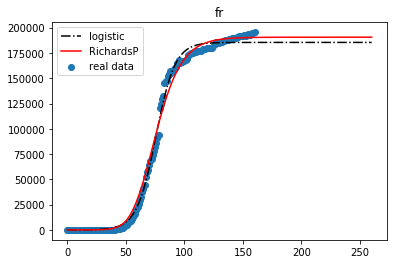

In [13]:
fit_params = Parameters()
fit_params.add('K', value=10e4,vary=True)
fit_params.add('tc', value=53,vary=False)
fit_params.add('eps', value=10,vary=False)
fit_params.add('gamma', value=1, min=0)
fit_params.add('p', value=0.1, min=0,max=0.99)
fit_params.add('r', value=1, min=0)

data=getCountryData("Fr")
n=data.shape[0]
print(n)
x=np.linspace(1,n,n)
y0=1

out = minimize(objective, fit_params,  args=(f,x,data,y0))
report_fit(out.params)
x=np.linspace(1,n+100,n+100)
sim=f(out.params,x,1)
fitFor("fr",100)
#plt.figure()

plt.plot(sim,label="RichardsP",color="red")
#plt.plot(data,linestyle="dotted",label="real")
plt.legend()
plt.savefig("finalresult.png", dpi=150)

158
[[Variables]]
    K:      195981.034 +/- 1034.55263 (0.53%) (init = 100000)
    tc:     50 (fixed)
    eps:    10 (fixed)
    gamma:  0.15945016 +/- 0.00322035 (2.02%) (init = 1)
    p:      0.98997702 +/- 0.00530898 (0.54%) (init = 0.99)
    r:      0.35812813 +/- 0.00491041 (1.37%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, r) = -0.779
    C(K, p)     = -0.775
    C(gamma, p) = -0.733
    C(K, gamma) =  0.487
    C(p, r)     =  0.197


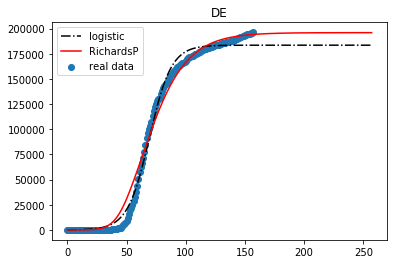

In [14]:
fit_params = Parameters()
fit_params.add('K', value=10e4,vary=True)
fit_params.add('tc', value=50,vary=False)
fit_params.add('eps', value=10,vary=False)
fit_params.add('gamma', value=1, min=0)
fit_params.add('p', value=1, min=0,max=0.99)
fit_params.add('r', value=1, min=0)

data=getCountryData("DE")
n=data.shape[0]
print(n)
x=np.linspace(1,n,n)
y0=1

out = minimize(objective, fit_params,  args=(f,x,data,y0))
report_fit(out.params)
x=np.linspace(1,n+100,n+100)
sim=f(out.params,x,1)
fitFor("DE",100)
#plt.figure()

plt.plot(sim,label="RichardsP",color="red")
#plt.plot(data,linestyle="dotted",label="real")
plt.legend()
plt.savefig("finalresult.png", dpi=150)

# Equation2.5

# 1. K(t)

$$ K{(t)}= \frac{ K{(t_0)} \exp(\alpha t)}{ 1+  \frac{K(t_0)}{K_\alpha} \big(\exp(\alpha t)-1)}$$

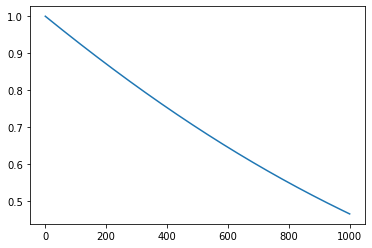

In [28]:
def K(t,K0,alpha,Kalpha):
    return K0*np.exp(alpha*t)/(1+(K0/Kalpha)*(np.exp(alpha*t)-1))
x=np.linspace(0,1000,1001)
plt.plot(x,K(x,1,-0.001,3))
#plt.plot(x,K(x,10,-0.001,100))
#plt.plot(x,K(x,1,-0.001,5))

# 2. P(t)
\begin{equation}\label{p}
p_\delta(t)=
\begin{cases}
\displaystyle 1  &\qquad \mbox{if}  \qquad  t\leq t_c\\ 
\displaystyle  \frac{p^\star-1}{\delta} (t-t_c) + 1 & \qquad \mbox{if}  \qquad t_c \leq t\leq t_c+\delta\\ 
\displaystyle  p^\star  &\qquad \mbox{if}  \qquad   t_c+\delta \leq t \leq  t_d-\delta \\
\displaystyle  \frac{1-p^\star}{\delta} (t-t_d) + 1 & \qquad \mbox{if}  \qquad t_d-\delta \leq t\leq t_d\\ 
\displaystyle 1  &\qquad \mbox{if}  \qquad  t\geq t_d \\ 
\end{cases}
\end{equation}

In [ ]:
def Pdelta(p,Tc,Td,Tmax,delta):
    P=np.ones(Tmax)
    for i in range(Tc,Tc+delta+1):
      P[i]=1+(p-1)*(i-Tc)/delta 
    for i in range(Tc+delta+1,Td+1):
      P[i]=p
    for i in range(Td-delta,Tmax+1):
      P[i]=p
    return P

def l(r,P):
    return np.power(r,P)

# Equation 2.5
\begin{equation}\label{LogisticP}
\begin{cases}
\displaystyle \frac{ d\:I_{c}(t)}{d\:t} = -r  I^{p_\delta(t)}_c(t) \Big(1- \big(\frac{I_{c}(t)}{K(t)}\big)^{\gamma} \Big) \\ \\
\displaystyle \frac{ d\:K(t)}{d\:t} = \alpha  K(t) \Big(1- \frac{K(t)}{K_\alpha}\Big) 
\end{cases}
\end{equation}
In  general, after the start of the evolution of the epidemic, there is a  large reduction of infected by a social distancing measures.  For that, we assume that
 $ p(t)=1 $  for $t_d\leq t\leq t_c$ and $ p(t) ={p^\star}$  with $0\leq {p^\star}<1$ , where $t_c$ and $t_d$ are  the time of beginning and stopping  confinement respectively . A typical examples is 
 where $p_\delta(t)$ a continuous function  such that


In [57]:
def getParams(K0,alpha,Kalpha,r,gamma,p):
    fit_params = Parameters()
    fit_params.add('K0', value=K0,vary=False)
    fit_params.add('p', value=p,min=1, max=1e6)
    fit_params.add('gamma', value=gamma)
    fit_params.add('Kalpha', value=Kalpha)
    fit_params.add('alpha', value=alpha)
    fit_params.add('r', value=r)
    return fit_params

In [58]:
def deriv2(y, x, K0,alpha, Kalpha , r,gamma, p):
    I= y
    dIdt=-r*(I**p)(1-(I/K(x,K0,alpha,Kalpha))**gamma)
    return dIdt

In [65]:
def f(params,x,y0):
    K0= params["K0"]
    p= params["p"].value
    r= params["r"].value
    gamma= params["gamma"].value
    Kalpha= params["Kalpha"].value
    alpha= params["alpha"].value
    return odeint(deriv2, y0, x, args=(K0,alpha,Kalpha, r, gamma, p))

In [67]:
params=getParams(0,7,7000,-0.1,1,1)
x=np.linspace(1,100,100)
y=f(params,x,1)

/home/gnu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: 'numpy.ndarray' object is not callable

# Equation 3.2

\begin{equation}
 \begin{cases}
\displaystyle \frac{ d v_c}{d t} & \displaystyle= r^2 p I^{2p-1}_c \Big[1-(1+\frac{\gamma}{p}) \Big(\frac{I_c}{K}\Big)^\gamma \Big]  \Big(1- \Big(\frac{I_{c}}{K}\big)^{\gamma} \Big) \\ \\
\displaystyle \frac{ d I_c}{d t}&=v_c
\end{cases}
\end{equation}


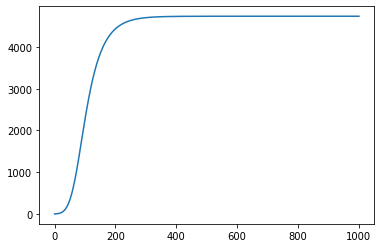

In [27]:
#@title Titre par défaut
y0=[1,0]
def wave(y, x, r,gamma,p,k):
  I, v = y
  A=np.power(r,2)*p*np.power(I,2*p-1)
  B=1.-(1.+(gamma/p))*np.power(I/k,gamma)
  C=1.-np.power(I/k,gamma)
  dIdt=A*B*C
  dvdt=0.5*I
  return dIdt,dvdt
#def GG(y, t):
#    return np.diag([0, 0, 0, 100])

n=1000
x= np.linspace(0, n, 10*n)

sol = odeint(wave, y0, x, args=(0.5,1,0.9,1e4)).T
plt.plot(x,sol[0])



Text(0, 0.5, 'y')

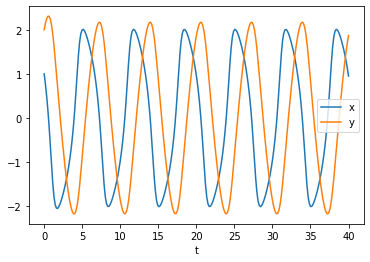

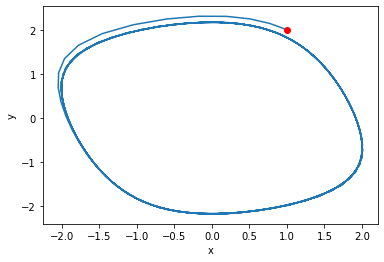

In [34]:
mu = 1.0

def vanderpol(X, t):
    x = X[0]
    y = X[1]
    dxdt = mu * (x - 1./3.*x**3 - y)
    dydt = x / mu
    return [dxdt, dydt]

X0 = [1, 2]
t = np.linspace(0, 40, 250)

sol = odeint(vanderpol, X0, t)
x = sol[:, 0]
y = sol[:, 1]

plt.plot(t,x, t, y)
plt.xlabel('t')
plt.legend(('x', 'y'))


# phase portrait
plt.figure()
plt.plot(x,y)
plt.plot(x[0], y[0], 'ro')
plt.xlabel('x')
plt.ylabel('y')

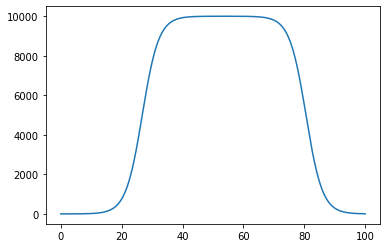

In [29]:
#@title Titre par défaut
y0=[1,0]
def wave(y, x, r,gamma,p,k):
  I, v = y
  A=np.power(r,2)*p*np.power(I,2*p-1)
  B=1-(1+(gamma/p))*np.power(I/k,gamma)
  C=1-np.power(I/k,gamma)
  dvdt=A*B*C
  dIdt=v
  return dIdt,dvdt
n=100
x= np.linspace(0, n, 10*n)

sol = odeint(wave, y0, x, args=(0.37,1,1,1e4)).T
plt.plot(x,sol[0])